In [1]:
import os
picPath='C:\\VSCode_Test\\ImageTest\\Flowsers\\archive\\flowers'
print(os.listdir(picPath))

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


1 ) Importing Various Modules.

In [2]:
%pip install seaborn
%pip install keras
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always') 
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

2.準備資料

2.1 創建函數以從圖像中獲取訓練和驗證集。

In [4]:
X=[]
Z=[]
IMG_SIZE=150 #設定圖片大小
FLOWER_DAISY_DIR=f'{picPath}\\daisy'
FLOWER_SUNFLOWER_DIR=f'{picPath}\\sunflower'
FLOWER_TULIP_DIR=f'{picPath}\\tulip'
FLOWER_DANDI_DIR=f'{picPath}\\dandelion'
FLOWER_ROSE_DIR=f'{picPath}\\rose'

下方程式碼的主要目的是為了建立訓練資料集。它會讀取指定目錄(DIR)下的所有圖片，
並將每一張圖片縮放到指定的大小(IMG_SIZE)。
每一張圖片都會被轉換成NumPy陣列並添加到列表X中。
同時，每一圖片的標籤（由函數assign_label指定）會被添加到列表Z中。
在這個情況下，標籤就是花的類型(flower_type)

In [5]:
def assign_label(img,flower_type):
    return flower_type

def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))



In [6]:
#列印圖片數量
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))




100%|██████████| 764/764 [00:03<00:00, 233.18it/s]


764


100%|██████████| 733/733 [00:03<00:00, 192.83it/s]


1497


100%|██████████| 984/984 [00:04<00:00, 229.15it/s]


2481


100%|██████████| 1052/1052 [00:04<00:00, 245.58it/s]


3533


100%|██████████| 784/784 [00:03<00:00, 250.41it/s]

4317


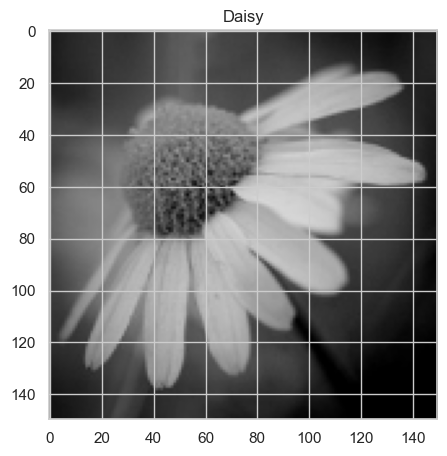

In [7]:
#列印daisy的第一張圖片
plt.imshow(X[10])
plt.title(Z[10])
plt.show()



2.2視覺化一些隨機圖像

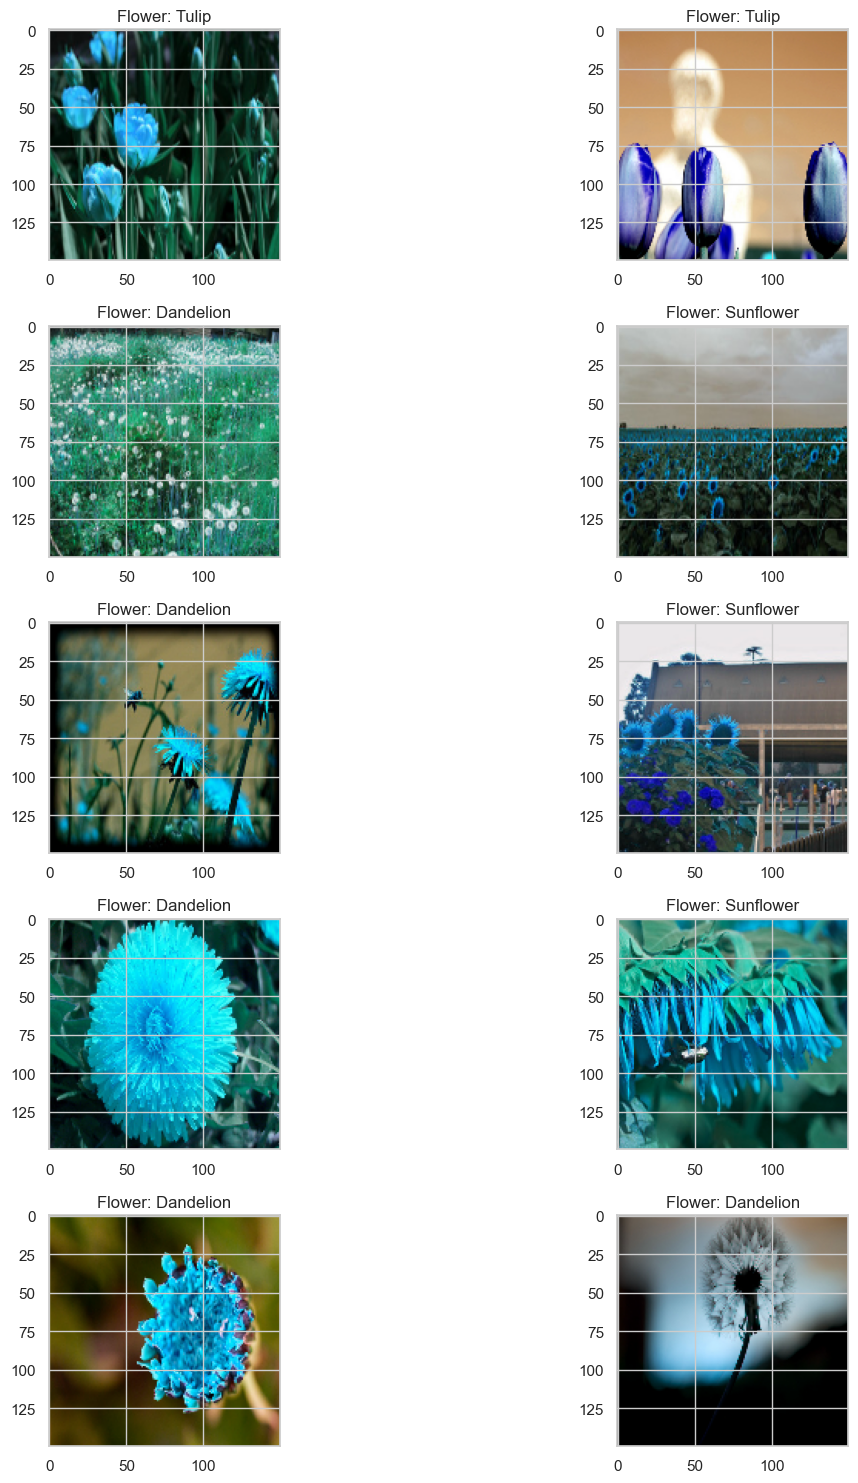

In [8]:
fig,ax=plt.subplots(5,2)  #建立5*2的圖表
fig.set_size_inches(15,15)  #設定圖表大小15*15
for i in range(5):           #列印5張圖片
    for j in range (2):
        l=rn.randint(0,len(Z))    #隨機從列表Z選取一張圖片
        ax[i,j].imshow(X[l])      #列印圖片
        ax[i,j].set_title('Flower: '+Z[l])     #列印圖片標籤
        
plt.tight_layout()   #自動調整子圖參數，使之填充整個圖像區域

2.3 對Y陣列進行標籤編碼（例如：Daisy->0，Rose->1等），然後進行獨熱編碼。

這段程式碼的目的是為了準備機器學習模型的訓練資料。以下是每行程式碼的解釋：
1. `le = LabelEncoder()`：創建一個 LabelEncoder 物件。LabelEncoder 是一種將類別標籤轉換為數字的工具，這對於許多機器學習算法是必要的，因為它們需要數值輸入。
2. `Y = le.fit_transform(Z)`：將 Z 列表中的標籤轉換成數字。這裡的 `fit_transform` 方法首先學習數據（找出所有唯一的類別標籤），然後將這些標籤轉換為數字。
3. `Y = to_categorical(Y, 5)`：將數字轉換成二進制矩陣。這是為了使用 one-hot 編碼，這是一種常見的表示類別變量的方法。在這種情況下，每種花的類型都會有一個唯一的二進制向量來表示。
4. `X = np.array(X)`：將 X 列表轉換成 NumPy 陣列。這是因為 NumPy 陣列在數學運算上比 Python 原生的列表更有效率。
5. `X = X / 255`：將 X 列表中的數字標準化。這是因為圖片的像素值範圍通常是 0 到 255。通過除以 255，我們將所有的像素值範圍縮放到 0 到 1 之間。這種標準化的過程可以幫助機器學習模型更好地學習。

In [9]:
#2.3
le=LabelEncoder()       #將標籤轉換成數字
Y=le.fit_transform(Z)   #將Z列表中的標籤轉換成數字
Y=to_categorical(Y,5)   #將數字轉換成二進制矩陣
X=np.array(X)           #將X列表轉換成NumPy陣列
X=X/255                 #將X列表中的數字標準化

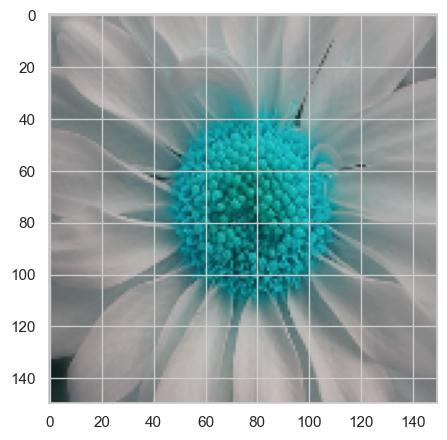

X: [[[0.5254902  0.53333333 0.53333333]
  [0.56078431 0.56470588 0.56470588]
  [0.57647059 0.57647059 0.57647059]
  ...
  [0.58823529 0.59607843 0.59607843]
  [0.59607843 0.60392157 0.60392157]
  [0.59607843 0.59607843 0.59607843]]

 [[0.51764706 0.5254902  0.5254902 ]
  [0.55686275 0.56078431 0.56078431]
  [0.57254902 0.57254902 0.57254902]
  ...
  [0.58823529 0.59607843 0.59607843]
  [0.59215686 0.6        0.6       ]
  [0.59215686 0.59215686 0.59215686]]

 [[0.51372549 0.5254902  0.5254902 ]
  [0.54509804 0.55294118 0.55686275]
  [0.56862745 0.56470588 0.57254902]
  ...
  [0.59607843 0.60392157 0.60392157]
  [0.58823529 0.59215686 0.59215686]
  [0.57647059 0.57647059 0.57647059]]

 ...

 [[0.10196078 0.18431373 0.17254902]
  [0.09803922 0.18039216 0.16862745]
  [0.10196078 0.18431373 0.17254902]
  ...
  [0.49019608 0.49411765 0.50980392]
  [0.48627451 0.49019608 0.50588235]
  [0.49019608 0.49411765 0.50980392]]

 [[0.10196078 0.18431373 0.17254902]
  [0.10196078 0.18431373 0.1725490

In [19]:
# 假設 X 是圖像資料
plt.imshow(X[0])
plt.show()

# 印出對應的 Y, Z 值
print('X:', X[0])
print('Y:', Y[0])
print('Z:', Z[0])

2.4 分割為訓練集和驗證集。

In [25]:
#2.4
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)
#將資料分成訓練集和測試集，其中測試集的比例為0.25
#random_state是隨機數的種子,42是隨便設定的一個數字

2.5 設置隨機種子

In [26]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

3.建立模型

3.1 建立卷積神經網絡模型

In [27]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
# # 建模開始使用卷積神經網絡（CNN）。

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

3.2 使用學習率退火器

In [29]:
batch_size=128  #128個訓練樣本被送入網絡中進行訓練
epochs=50       #訓練50次

#導入回調函數
from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)
#patience=3 如果驗證準確率在3個訓練週期內沒有改進，則進行學習率調整。
#verbose=1在回調函數觸發時，會在訓練輸出中顯示一條消息。
#factor=0.1 當觸發學習率調整時，新的學習率將是原來學習率的0.1倍。

3.3 數據增強以防止過擬合

In [30]:
#設置了多個圖像增強的方式，包括旋轉、縮放、平移和翻轉等
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

3.4 編譯 Keras 模型和摘要

In [31]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 18, 18, 96)       

3.5 在訓練集上擬合模型並在驗證集上進行預測

In [33]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/50



25/25 [==============================] - 38s 1s/step - loss: 1.5577 - accuracy: 0.3570 - val_loss: 1.1471 - val_accuracy: 0.5074
Epoch 2/50
25/25 [==============================] - 34s 1s/step - loss: 1.1920 - accuracy: 0.4960 - val_loss: 1.0840 - val_accuracy: 0.5000
Epoch 3/50
25/25 [==============================] - 32s 1s/step - loss: 1.1050 - accuracy: 0.5597 - val_loss: 1.0231 - val_accuracy: 0.6111
Epoch 4/50
25/25 [==============================] - 33s 1s/step - loss: 1.0383 - accuracy: 0.5902 - val_loss: 0.9721 - val_accuracy: 0.6065
Epoch 5/50
25/25 [==============================] - 65s 3s/step - loss: 0.9675 - accuracy: 0.6262 - val_loss: 0.9755 - val_accuracy: 0.5954
Epoch 6/50
25/25 [==============================] - 35s 1s/step - loss: 0.9196 - accuracy: 0.6452 - val_loss: 0.8549 - val_accuracy: 0.6565
Epoch 7/50
25/25 [==============================] - 35s 1s/step - loss: 0.8843 - accuracy: 0.6674 - val_loss: 0.8935 - val_accuracy: 0.6444
Epoch 8/50
25/25 [=============

In [34]:
#將History存到一個檔案中
import pickle

with open('history.pkl', 'wb') as file_pi:
    pickle.dump(History.history, file_pi)

In [36]:
#取用History物件
import pickle
with open('history.pkl', 'rb') as file_pi:
    loaded_history = pickle.load(file_pi)

4. 評估模型性能

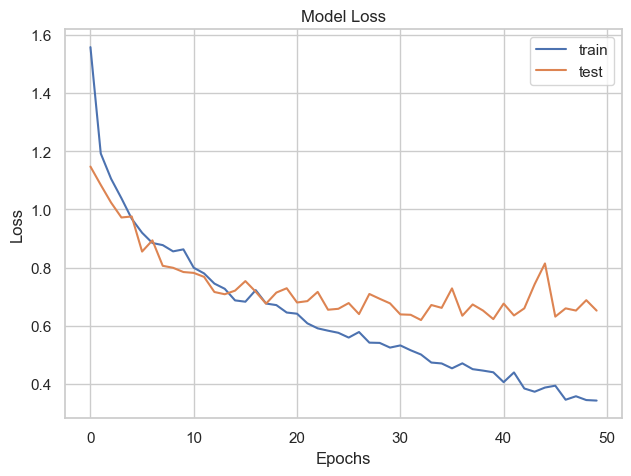

In [37]:
plt.plot(loaded_history['loss'])
plt.plot(loaded_history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

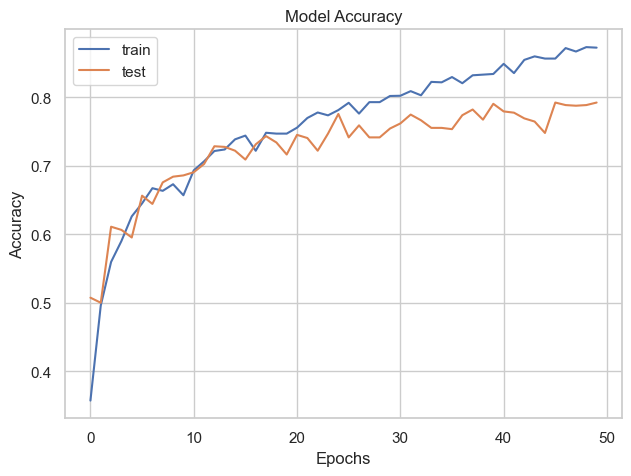

In [38]:
plt.plot(loaded_history['accuracy'])
plt.plot(loaded_history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

5. 在驗證集上可視化預測

In [39]:
# 用模型在測試集上進行預測
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

34/34 [==============================] - 2s 61ms/step


In [41]:
# 現在儲存一些正確分類和錯誤分類的索引。'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

正確分類的花朵圖像

這段程式碼的主要目的是繪製一個 4x2 的子圖，每個子圖都顯示一個從 `x_test` 中選取的圖像，並且在每個圖像下方顯示模型預測的花朵類型和實際的花朵類型。

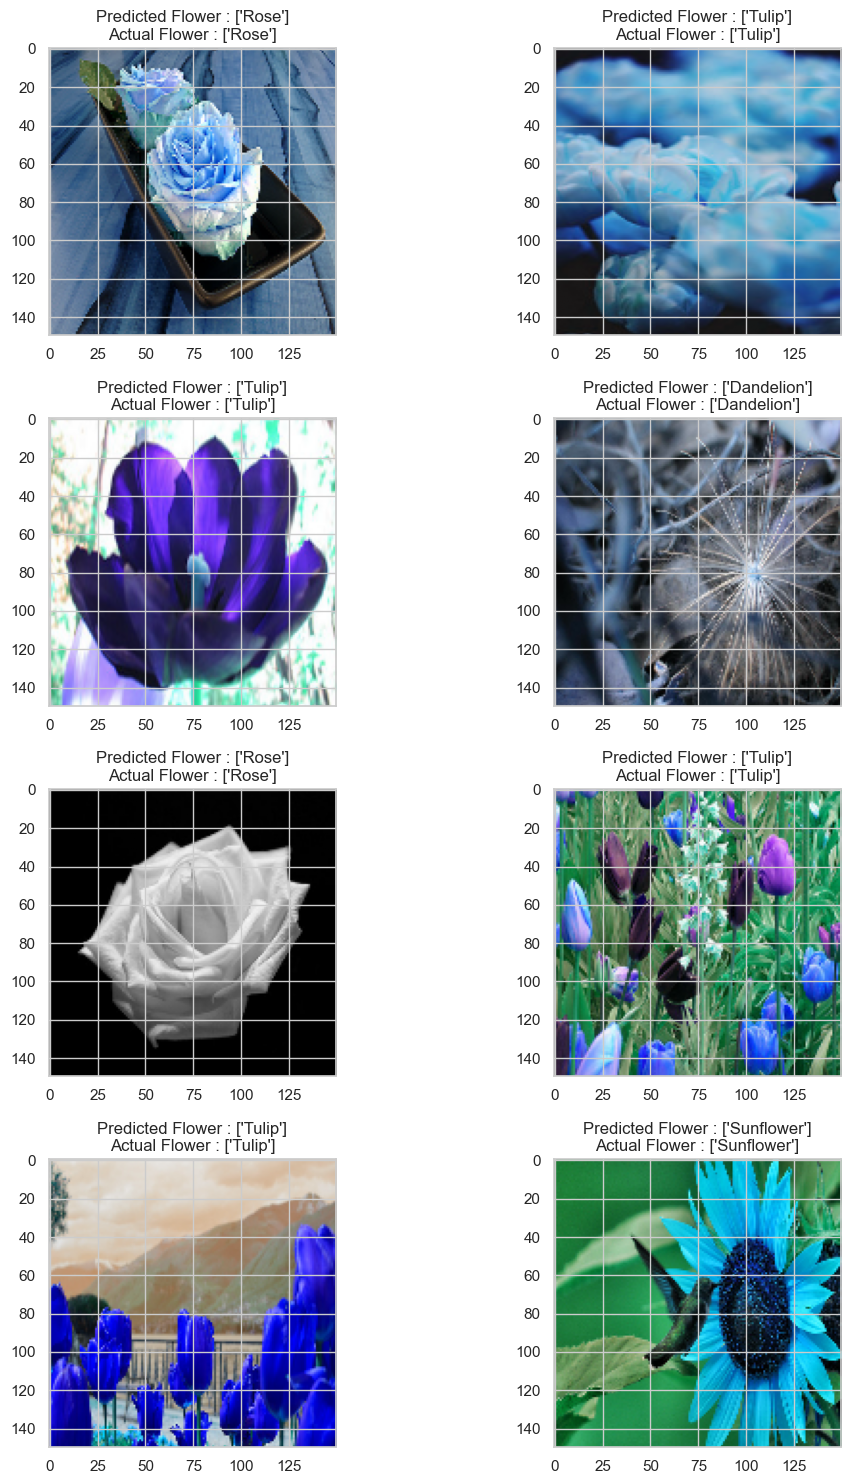

In [42]:
import warnings
warnings.filterwarnings('always') #所有警告都要顯示
warnings.filterwarnings('ignore') #忽略所有警告。

count=0
fig,ax=plt.subplots(4,2) #建立4*2的圖表
fig.set_size_inches(15,15) #設定圖表大小15*15
for i in range (4):         #這兩個迴圈用於遍歷所有的子圖。
    for j in range (2):     
        ax[i,j].imshow(x_test[prop_class[count]])  #在子圖 `ax[i,j]` 中顯示 `x_test圖片`。
        #ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(np.argmax([y_test[prop_class[count]]]))))
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(np.array([np.argmax(y_test[prop_class[count]])]))))
        #設定子圖的標題，顯示模型預測的花朵類型和實際的花朵類型。
        plt.tight_layout()  #自動調整子圖參數，使得子圖之間的間距適當。
        count+=1         #計數器加1

錯誤分類的花朵圖像

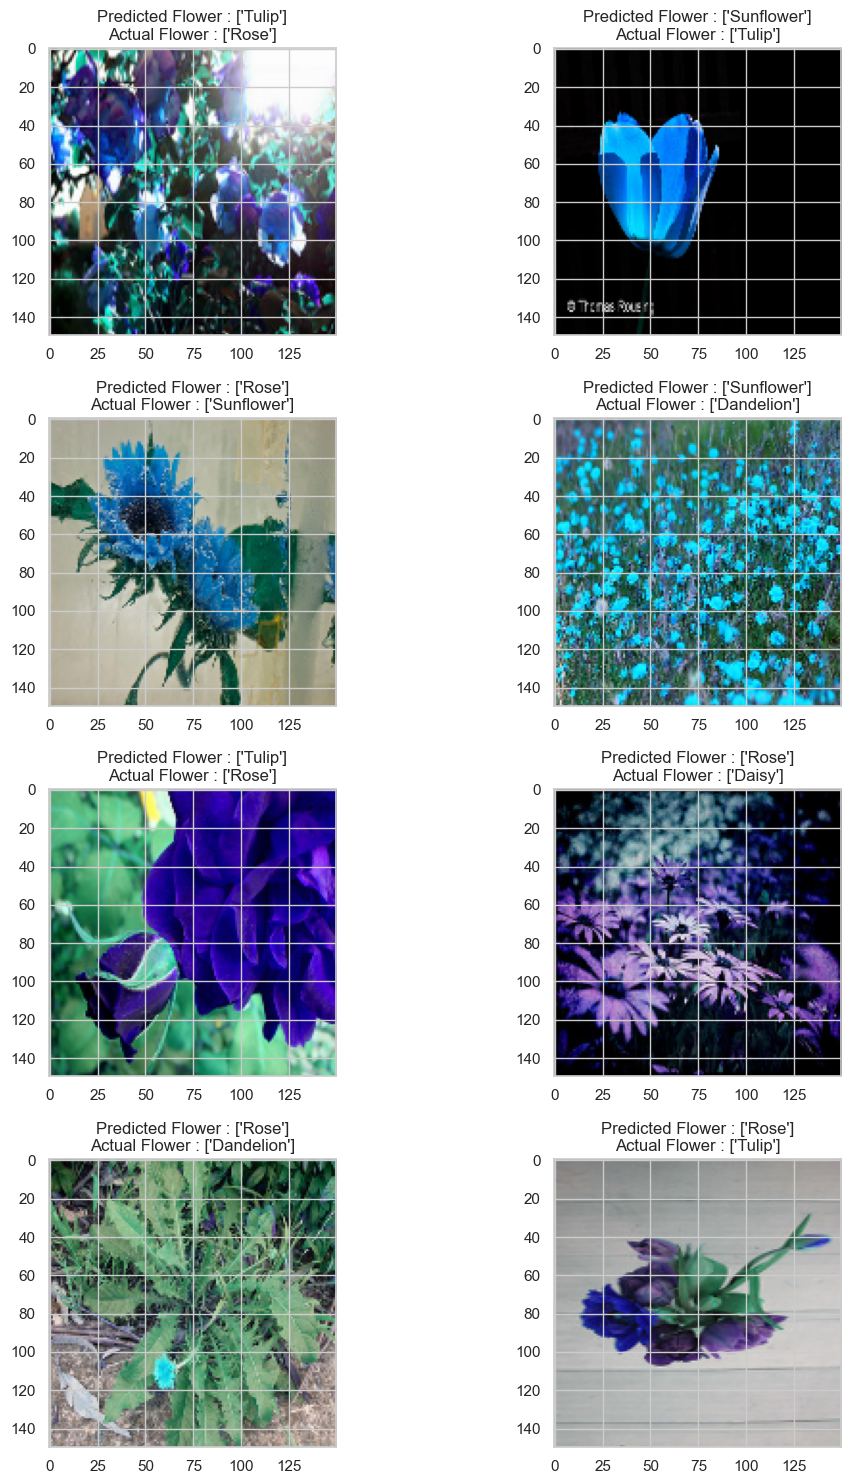

In [47]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(np.array([np.argmax(y_test[mis_class[count]])]))))
        plt.tight_layout()
        count+=1